# DATA 445 - Final Project Presentation

#### Group 4: Alessandra, Josiane, Norma, and Sylvio

## **1) Setup Section**

1.1) Installation

In [ ]:
# !pip install seaborn

1.2) Libraries

In [69]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import re
import os

from datetime import date
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

sns.set()
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
warnings.filterwarnings("ignore")

sns.__version__

'0.13.1'

1.3) Mount Google Drive and access files

In [70]:
# Global Variables
main_path = '/content/drive/My Drive/Colab Notebooks/dataset/'
final_files_path = main_path + 'Final Files/'
original_file_path = main_path + 'marketing_data.csv'
print('Setup of Global variables is done.')


# Global function to save files
def save_file(dim_df, file_name):
  output_path = final_files_path + file_name
  if os.path.exists(output_path):
      os.remove(output_path)
      print(f'Old file removed: {output_path}.')
  dim_df.to_csv(output_path, index=False)
  print(f'New file {file_name} created.')



Setup of Global variables is done.


In [71]:
# File System Operations

# Virtual driver mount
drive.mount('/content/drive')
print(f"Current working directory: {os.getcwd()}")

# Final Files Folder
if not os.path.exists(final_files_path):
    os.makedirs(final_files_path)
    print(f"Directory '{final_files_path}' created successfully.")
else:
    print(f"Directory '{final_files_path}' already exists.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content
Directory '/content/drive/My Drive/Colab Notebooks/dataset/Final Files/' already exists.


In [72]:
df = pd.read_csv(original_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

## **2) Data Preparation and Modeling Section**


2.1) Dimension


2.1.1) Dimension Country, Education, and Marital Status


In [73]:
dim_list = []
dim_list.append({'dim_name':'Country', 'file_name':'Dim_Country.csv','id_col':'Country_Id', 'original_col':'Country','final_col':'Country_Code'})
dim_list.append({'dim_name':'Education', 'file_name':'Dim_Education.csv','id_col':'Education_Id', 'original_col':'Education','final_col':'Education_Level'})
dim_list.append({'dim_name':'Marital_Status', 'file_name':'Dim_Marital_Status.csv','id_col':'Marital_Status_Id', 'original_col':'Marital_Status','final_col':'Marital_Status'})

for dim in dim_list:
  dim_df = df[[dim['original_col']]].drop_duplicates().reset_index(drop=True)
  dim_df[dim['id_col']] = dim_df.index + 1
  dim_df.rename(columns={dim['original_col']: dim['final_col']}, inplace=True)
  dim_df = dim_df[[dim['id_col'], dim['final_col']]]
  dim_name = dim['dim_name']
  print(f'Dimension {dim_name} processing done.')
  # Saving Dimension
  save_file(dim_df, dim['file_name'])
  print('- '*20)



Dimension Country processing done.
Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Dim_Country.csv.
New file Dim_Country.csv created.
- - - - - - - - - - - - - - - - - - - - 
Dimension Education processing done.
Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Dim_Education.csv.
New file Dim_Education.csv created.
- - - - - - - - - - - - - - - - - - - - 
Dimension Marital_Status processing done.
Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Dim_Marital_Status.csv.
New file Dim_Marital_Status.csv created.
- - - - - - - - - - - - - - - - - - - - 


2.1.2) Dimension Customer

In [74]:
df_dim_country = pd.read_csv(final_files_path + 'Dim_Country.csv')

df_dim_customer = pd.merge(df, df_dim_country, \
                       left_on='Country', right_on='Country_Code') \
                        [['ID', 'Year_Birth', 'Country_Id']]
df_dim_customer = df_dim_customer.rename(columns={'ID':'Customer_ID'})
print('Dimension Customer processing done.')

# Saving Dimension
save_file(df_dim_customer, 'Dim_Customer.csv')

Dimension Customer processing done.
Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Dim_Customer.csv.
New file Dim_Customer.csv created.


2.2) Creating Facts

2.2.1) Fact Customer Demographic

In [75]:
df = pd.read_csv(original_file_path)
df_dim_customer = pd.read_csv(final_files_path + 'Dim_Customer.csv')
df_dim_education = pd.read_csv(final_files_path + 'Dim_Education.csv')
df_dim_marital_status = pd.read_csv(final_files_path + 'Dim_Marital_Status.csv')

df_fct_demographic = pd.merge(df,df_dim_customer, left_on='ID', right_on='Customer_ID')
df_fct_demographic = pd.merge(df_fct_demographic,df_dim_education, left_on='Education', right_on='Education_Level')
df_fct_demographic = pd.merge(df_fct_demographic,df_dim_marital_status, left_on='Marital_Status', right_on='Marital_Status')

df_fct_demographic = df_fct_demographic[['Customer_ID','Year_Birth_x', 'Education_Id','Marital_Status_Id','Kidhome','Teenhome',' Income ']]

current_year = date.today().year

df_fct_demographic['Age'] = df_fct_demographic['Year_Birth_x'].apply(lambda x: current_year - x if pd.notnull(x) and x > 0 else None)
df_fct_demographic['Age'] = df_fct_demographic['Age'] <= 100
df_fct_demographic['Age'] = df_fct_demographic[df_fct_demographic['Age'] < 100]['Age']

df_fct_demographic = df_fct_demographic.drop(columns=['Year_Birth_x'])
df_fct_demographic = df_fct_demographic.rename(columns={'Income ':'Income'})

# Saving Dimension
save_file(df_fct_demographic, 'Fct_Customer_Demorgraphic.csv')


Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Fct_Customer_Demorgraphic.csv.
New file Fct_Customer_Demorgraphic.csv created.


2.2.2) Fact Customer Behavior

In [76]:
df = pd.read_csv(original_file_path)
df_dim_customer = pd.read_csv(final_files_path + 'Dim_Customer.csv')

df_fct_customer_behavior = pd.merge(df,df_dim_customer, left_on='ID', right_on='Customer_ID')

# print(df_fct_campaign_impact.head())
df_fct_customer_behavior = df_fct_customer_behavior[['Customer_ID','Recency','Complain', \
                                                 'NumWebPurchases','NumStorePurchases',\
                                                 'MntWines','MntFruits','MntMeatProducts', \
                                                 'MntFishProducts','MntSweetProducts', \
                                                 'MntGoldProds']]

# Saving Dimension
save_file(df_fct_customer_behavior, 'Fct_Customer_Behavior.csv')


Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Fct_Customer_Behavior.csv.
New file Fct_Customer_Behavior.csv created.


2.2.3) Fact Campaign Impact

In [77]:
df = pd.read_csv(original_file_path)
df_dim_customer = pd.read_csv(final_files_path + 'Dim_Customer.csv')

df_fct_campaign_impact = pd.merge(df,df_dim_customer, left_on='ID', right_on='Customer_ID')

# print(df_fct_campaign_impact.head())
impact_columns_list = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
df_fct_campaign_impact = df_fct_campaign_impact[['Customer_ID','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']]
df_fct_campaign_impact[impact_columns_list] = df_fct_campaign_impact[impact_columns_list].astype(bool)

# Saving Dimension
save_file(df_fct_campaign_impact, 'Fct_Campaign_Impact.csv')


Old file removed: /content/drive/My Drive/Colab Notebooks/dataset/Final Files/Fct_Campaign_Impact.csv.
New file Fct_Campaign_Impact.csv created.


## **3)  Predictive Analytics Section**

3.1) Loand and otimization data

In [78]:
df_base = pd.read_csv(original_file_path)

# Memory usage before conversion
memory_before = df_base.memory_usage(deep=True).sum()

df_base.rename(columns={' Income ':'Income'}, inplace=True)
df_base['Education'] = df_base['Education'].astype('category')
df_base['Year_Birth'] = df_base['Year_Birth'].astype('category')
df_base['Marital_Status'] = df_base['Marital_Status'].astype('category')
df_base['Country'] = df_base['Country'].astype('category')

df_base['Income'] = df_base['Income'].astype(str).str.replace('$', '')
df_base['Income'] = df_base['Income'].astype(str).str.replace(' ', '')
df_base['Income'] = df_base['Income'].astype(str).str.replace(',', '')
df_base['Income'] = df_base['Income'].astype('float32')

int_cols = df_base.select_dtypes(include=['int64']).columns
df_base[int_cols] = df_base[int_cols].astype('int8')

df_base['Dt_Customer'] = pd.to_datetime(df_base['Dt_Customer'], format='%m/%d/%y')

# Memory usage after conversion
memory_after = df_base.memory_usage(deep=True).sum()
memory_saved = memory_before - memory_after


print(f"Memory usage before\t:\t {round(memory_before/1024,2)} Kb")
print(f"Memory usage after\t:\t {round(memory_after/1024,2)} Kb")
print(f"Memory saved\t\t:\t {round(memory_saved/1024,2)} Kb")
print(f"\t\t\t:\t {round(memory_saved/memory_before*100, 2)}% of reduction in memory usage")


Memory usage before	:	 1101.22 Kb
Memory usage after	:	 87.79 Kb
Memory saved		:	 1013.43 Kb
			:	 92.03% of reduction in memory usage


3.2) Data Cleansing

In [79]:

int_cols = df_base.select_dtypes(include=['int8']).columns
df_base[int_cols] = df_base[int_cols].fillna(0)

df_base['Income'] = df_base['Income'].fillna(df_base['Income'].median())

df_base['Age'] = current_year - df['Year_Birth']
df_base['Age'] = df_base[df_base['Age'] < 100]['Age']

df_base['AnyCampaignAccepted'] = (df_base[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].any(axis=1)).astype(int)

nan_summary = df_base.isnull().sum()
print(nan_summary)


ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Response               0
Complain               0
Country                0
Age                    3
AnyCampaignAccepted    0
dtype: int64


3.3) Business Question 1 Prediction - Demograpich and Behavior

In [80]:
# Organization of fields by type

demographic_fields_list = [
    'Education', 'Marital_Status','Income',
    'Kidhome','Teenhome','Country','Age'
]
behavior_fields_list = [
    'Recency','NumDealsPurchases','NumWebPurchases',
    'NumCatalogPurchases','NumStorePurchases',
    'NumWebVisitsMonth','Complain'
]
product_fields_list = [
    'MntWines','MntFruits','MntMeatProducts',
    'MntFishProducts','MntSweetProducts','MntGoldProds'
]
ever_drop_list=[
    'ID', 'Dt_Customer','AnyCampaignAccepted',
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'Response', 'Year_Birth'
]

# Categorical columns
categorical_columns = ['Education', 'Marital_Status', 'Country']


In [81]:
# Generic Function to apply the random Forest
def apply_random_forest(df_local,
                        categorical_columns_list, drop_list,
                        target_variable,
                        test_size_value,random_state_value,n_estimators_value):
  label_encoders = {}
  for column in categorical_columns_list:
      le = LabelEncoder()
      df_local[column] = le.fit_transform(df_local[column])
      label_encoders[column] = le

  X = df_local.drop(columns=drop_list)
  y = df_local[target_variable]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_value, random_state=random_state_value)

  rf_model = RandomForestClassifier(n_estimators=n_estimators_value, random_state=random_state_value)
  rf_model.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:\n", classification_report(y_test, y_pred))

  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
  print(feature_importances)

  feature_importances.plot(kind='bar')
  plt.title('Feature Importances')
  plt.show()

Accuracy: 0.8303571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       353
           1       0.71      0.34      0.46        95

    accuracy                           0.83       448
   macro avg       0.78      0.65      0.68       448
weighted avg       0.82      0.83      0.81       448



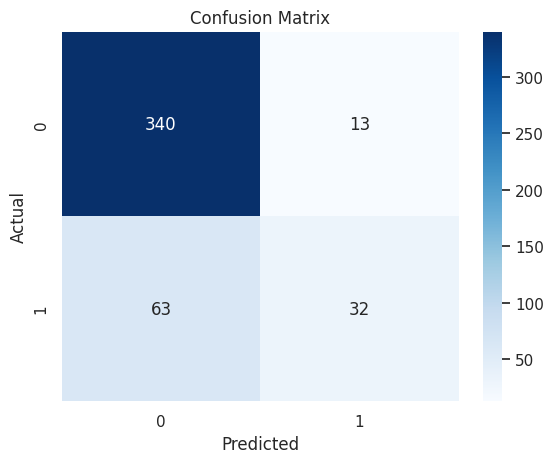

                     importance
Income                 0.139366
MntWines               0.073618
MntGoldProds           0.073616
NumCatalogPurchases    0.072474
MntMeatProducts        0.064308
Age                    0.063754
MntFishProducts        0.060676
Recency                0.060258
MntSweetProducts       0.058741
NumStorePurchases      0.053938
NumWebPurchases        0.053270
MntFruits              0.052604
NumWebVisitsMonth      0.043229
NumDealsPurchases      0.031903
Marital_Status         0.026423
Country                0.023284
Education              0.020467
Teenhome               0.014088
Kidhome                0.013534
Complain               0.000451


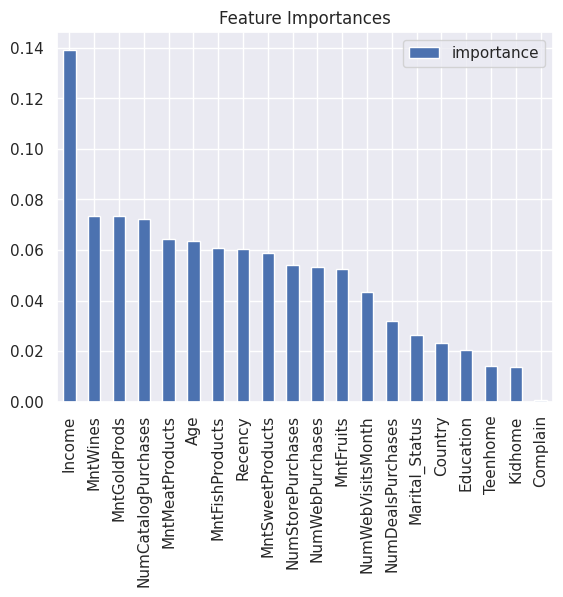

In [83]:
# Analysis with all fields (No Focus)

df_all = df_base.copy()
df_all = df_all.dropna(subset=['Age'])
apply_random_forest(df_all,
                    categorical_columns, ever_drop_list,
                    'AnyCampaignAccepted',
                    0.2, 42, 100)

Accuracy: 0.8102678571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       353
           1       0.60      0.33      0.42        95

    accuracy                           0.81       448
   macro avg       0.72      0.63      0.65       448
weighted avg       0.79      0.81      0.79       448



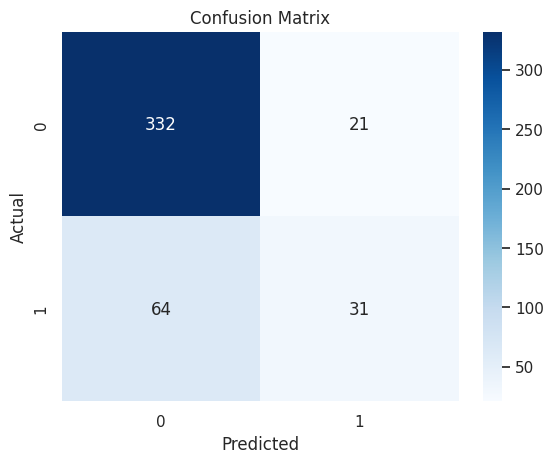

                importance
Income            0.445498
Age               0.245099
Marital_Status    0.090865
Country           0.090454
Education         0.061918
Kidhome           0.036630
Teenhome          0.029537


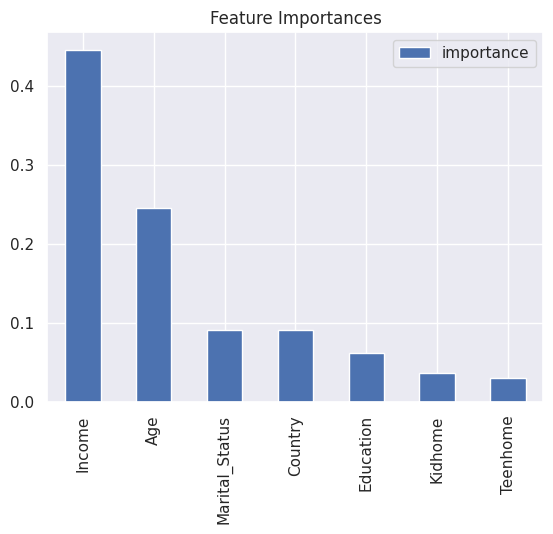

In [84]:
# Analysis with Demographic Focus

df_all = df_base.copy()
df_all = df_all.dropna(subset=['Age'])
apply_random_forest(df_all,
                    categorical_columns,
                    ever_drop_list+behavior_fields_list+product_fields_list,
                    'AnyCampaignAccepted',
                    0.2, 42, 100)

Accuracy: 0.8102678571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.89       353
           1       0.59      0.36      0.44        95

    accuracy                           0.81       448
   macro avg       0.71      0.64      0.67       448
weighted avg       0.79      0.81      0.79       448



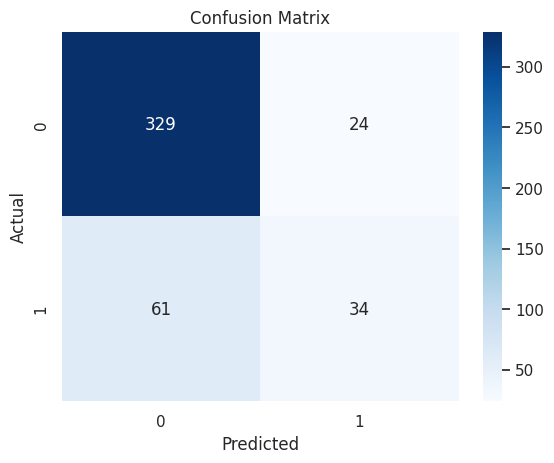

                     importance
Recency                0.275265
NumCatalogPurchases    0.185272
NumStorePurchases      0.150625
NumWebPurchases        0.143973
NumWebVisitsMonth      0.130264
NumDealsPurchases      0.112211
Complain               0.002390


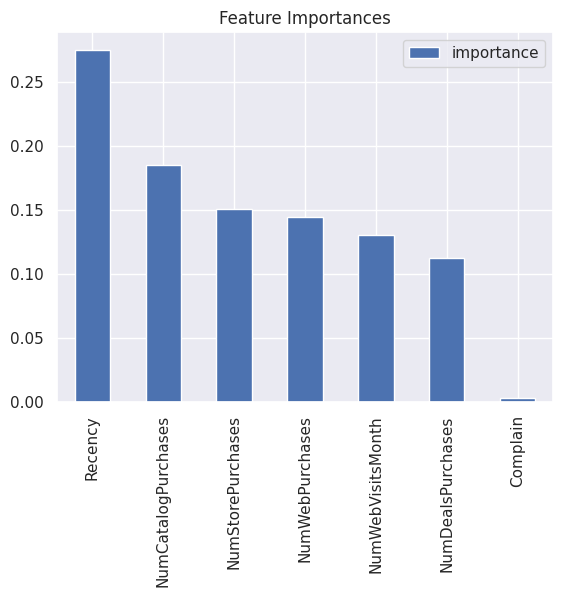

In [85]:
# Analysis with Behavior Focus

df_all = df_base.copy()
df_all = df_all.dropna(subset=['Age'])
apply_random_forest(df_all,
                    categorical_columns,
                    ever_drop_list+demographic_fields_list+product_fields_list,
                    'AnyCampaignAccepted',
                    0.2, 42, 100)

Accuracy: 0.8058035714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89       356
           1       0.58      0.20      0.29        92

    accuracy                           0.81       448
   macro avg       0.70      0.58      0.59       448
weighted avg       0.77      0.81      0.77       448



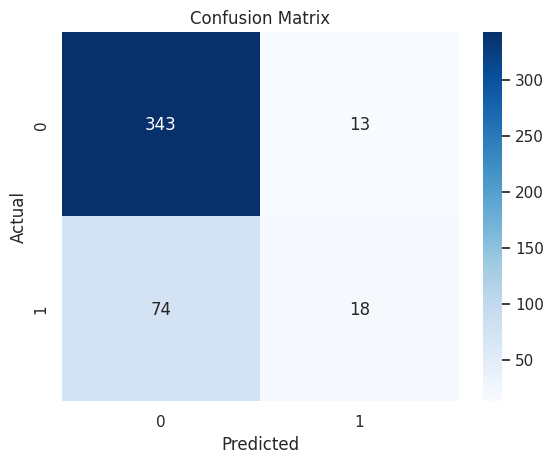

                  importance
MntWines            0.204686
MntGoldProds        0.192682
MntMeatProducts     0.176397
MntSweetProducts    0.146501
MntFishProducts     0.142069
MntFruits           0.137664


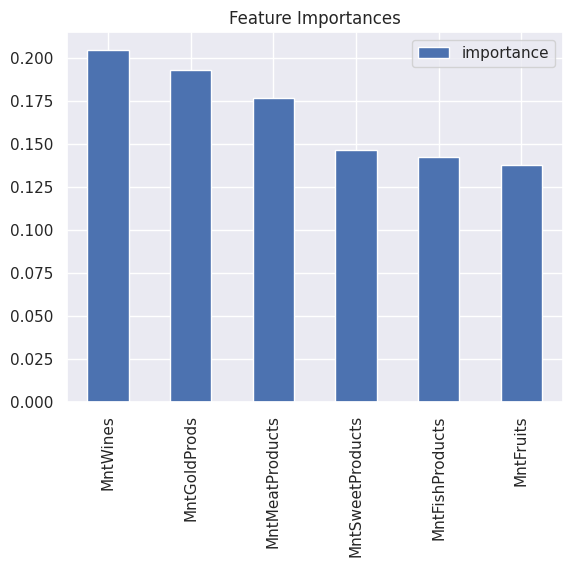

In [86]:
# Analysis with Products Focus

df_all = df_base.copy()
apply_random_forest(df_all,
                    categorical_columns,
                    ever_drop_list+demographic_fields_list+behavior_fields_list,
                    'AnyCampaignAccepted',
                    0.2, 42, 100)

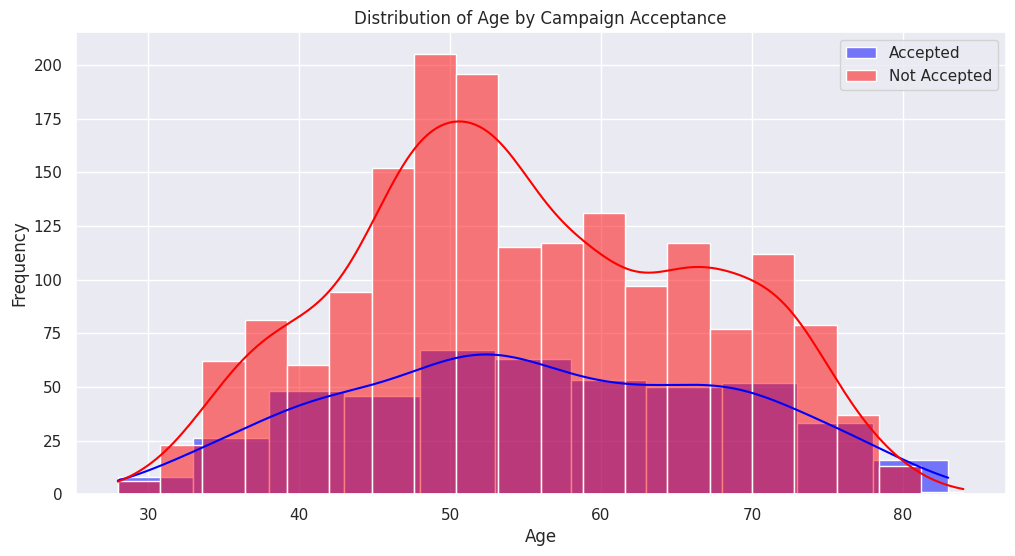

Mean Age (Accepted): 55.77
Mean Age (Not Accepted): 54.92


In [87]:
# Analysis with Age focus

plt.figure(figsize=(12, 6))
sns.histplot(df_base[df_base['AnyCampaignAccepted'] == 1]['Age'], kde=True, color='blue', label='Accepted')
sns.histplot(df_base[df_base['AnyCampaignAccepted'] == 0]['Age'], kde=True, color='red', label='Not Accepted')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age by Campaign Acceptance')
plt.legend()
plt.show()

mean_age_accepted = df_base[df_base['AnyCampaignAccepted'] == 1]['Age'].mean()
mean_age_not_accepted = df_base[df_base['AnyCampaignAccepted'] == 0]['Age'].mean()

print(f"Mean Age (Accepted): {round(mean_age_accepted,2)}")
print(f"Mean Age (Not Accepted): {round(mean_age_not_accepted,2)}")

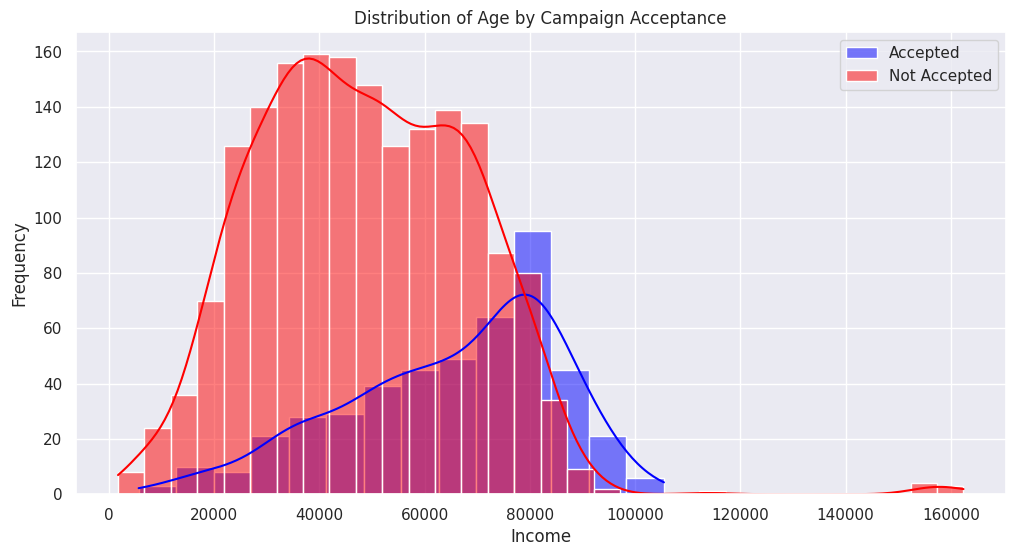

Mean Income (Accepted): 65135.71875
Mean Incom (Not Accepted): 48877.44921875


In [99]:
# Analysis with Income focus

df_income = df_base.copy()
df_income = df_income[df_income['Income'] <= 200000]

plt.figure(figsize=(12, 6))
sns.histplot(df_income[df_income['AnyCampaignAccepted'] == 1]['Income'], kde=True, color='blue', label='Accepted')
sns.histplot(df_income[df_income['AnyCampaignAccepted'] == 0]['Income'], kde=True, color='red', label='Not Accepted')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Age by Campaign Acceptance')
plt.legend()
plt.show()

mean_income_accepted = df_base[df_base['AnyCampaignAccepted'] == 1]['Income'].mean()
mean_income_not_accepted = df_base[df_base['AnyCampaignAccepted'] == 0]['Income'].mean()

print(f"Mean Income (Accepted): {round(mean_income_accepted,2)}")
print(f"Mean Incom (Not Accepted): {round(mean_income_not_accepted,2)}")

  AgeGroup  AnyCampaignAccepted
0    20-29             0.285714
1    30-39             0.219626
2    40-49             0.186715
3    50-59             0.190828
4    60-69             0.226981
5    70-79             0.216667
6    80-89             0.562500
7    90-99                  NaN


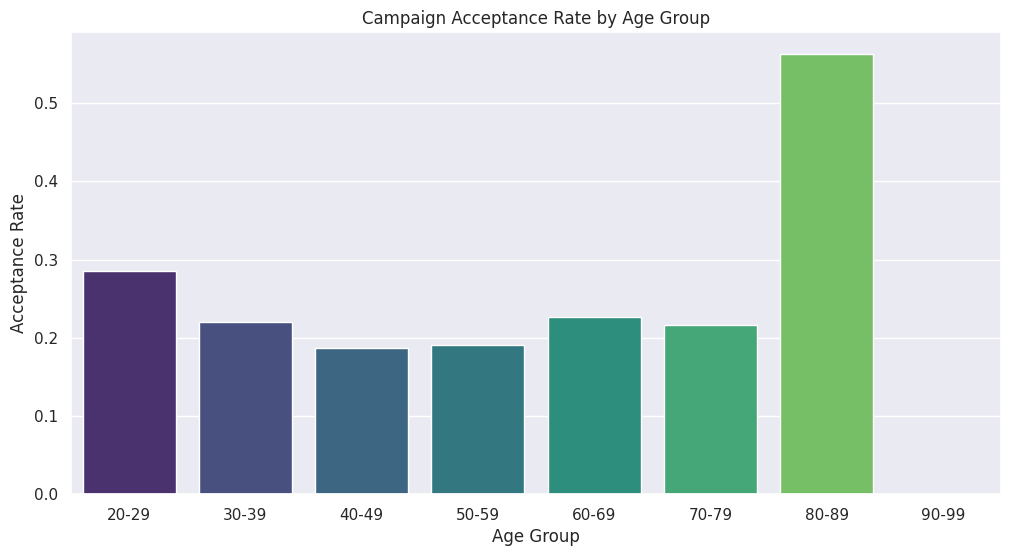

In [88]:
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df_base['AgeGroup'] = pd.cut(df_base['Age'], bins=age_bins, labels=age_labels, right=False)

acceptance_rate = df_base.groupby('AgeGroup')['AnyCampaignAccepted'].mean().reset_index()

# Exibir a taxa de aceitação por faixa etária
print(acceptance_rate)

# Plotar a taxa de aceitação por faixa etária
plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='AnyCampaignAccepted', data=acceptance_rate, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Acceptance Rate')
plt.title('Campaign Acceptance Rate by Age Group')
plt.show()

      IncomeGroup  AnyCampaignAccepted
0     10000-19999             0.112245
1     20000-29999             0.053498
2     30000-39999             0.104972
3     40000-49999             0.128049
4     50000-59999             0.189349
5     60000-69999             0.191617
6     70000-79999             0.336770
7     80000-89999             0.564417
8     90000-99999             0.853659
9   100000-199999             0.333333
10  200000-299999                  NaN
11  300000-399999                  NaN
12  400000-499999                  NaN
13  500000-599999                  NaN


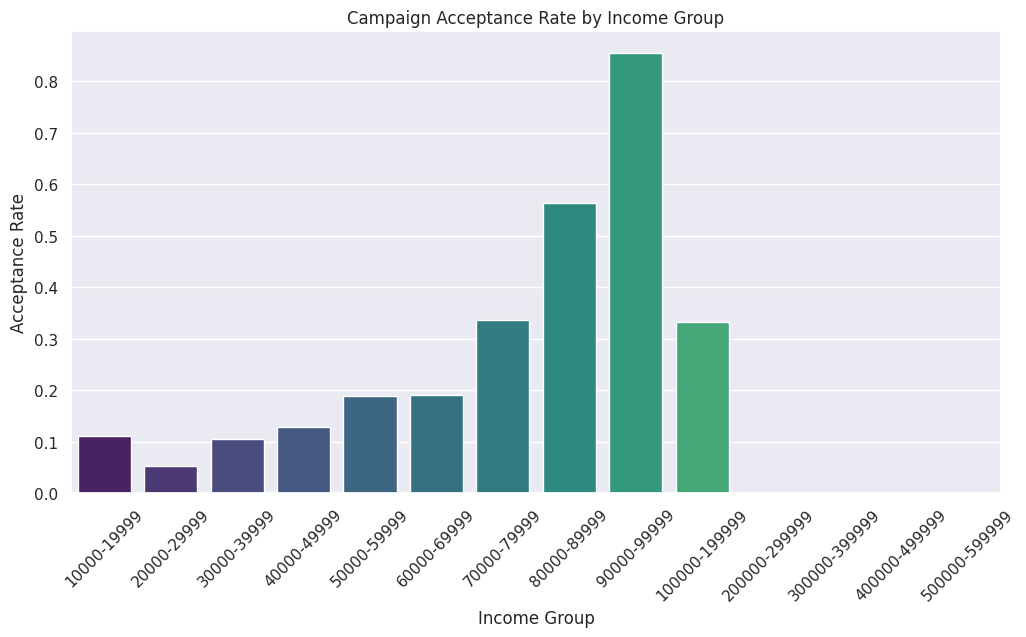

In [97]:
df_base_income = df_base.copy()

# Definir bins e labels corretamente
income_bins = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 300000, 400000, 500000, 600000]
income_labels = ['10000-19999', '20000-29999', '30000-39999', '40000-49999', '50000-59999', '60000-69999', '70000-79999', '80000-89999', '90000-99999', '100000-199999', '200000-299999', '300000-399999', '400000-499999', '500000-599999']
df_base_income['IncomeGroup'] = pd.cut(df_base_income['Income'], bins=income_bins, labels=income_labels, right=False)

# Calcular a taxa de aceitação por faixa de renda
income_acceptance_rate = df_base_income.groupby('IncomeGroup')['AnyCampaignAccepted'].mean().reset_index()

# Exibir a taxa de aceitação por faixa de renda
print(income_acceptance_rate)

# Plotar a taxa de aceitação por faixa de renda
plt.figure(figsize=(12, 6))
sns.barplot(x='IncomeGroup', y='AnyCampaignAccepted', data=income_acceptance_rate, palette='viridis')
plt.xlabel('Income Group')
plt.ylabel('Acceptance Rate')
plt.title('Campaign Acceptance Rate by Income Group')
plt.xticks(rotation=45)  # Rotacionar rótulos do eixo x para melhor visualização
plt.show()